In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from arch import arch_model

from scripts.renv_utils import activate_renv
from var_es_toolbox.data import load_data
from var_es_toolbox.models import forecast_ugarch

activate_renv()
from rpy2.robjects import pandas2ri, globalenv
%load_ext rpy2.ipython

- renv activated -- please restart the R session.


C:\Users\chris\Anaconda\envs\var-es-010\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
project_dir = Path.cwd().parent
# Asset
asset = "DPc1_return"
globalenv["asset"] = str(asset)

# Retrieve data
data_dir = project_dir / "data"
data_cleaned_name = "refinitiv_data_merged.csv"
date_format = "ISO8601"
data_cleaned = load_data(data_dir / data_cleaned_name, date_format=date_format)
futures_returns = data_cleaned[asset].dropna()

# Retrieve r model
models_dir = project_dir / "src" / "var_es_toolbox" / "models"
r_arch_models_path = models_dir / "r_arch_models.R"
r_hybrid_evt_models_path = models_dir / "r_hybrid_evt_models.R"
r_non_param_path = models_dir / "non_parametric_models.R"
r_gas_models_path = models_dir / "r_gas_models.R"
r_caviar_models_path = models_dir / "r_caviar_models.R"

globalenv['r_non_param_path'] = str(r_non_param_path)
globalenv['r_arch_models_path'] = str(r_arch_models_path)
globalenv['r_hybrid_evt_models_path'] = str(r_hybrid_evt_models_path)
globalenv['r_gas_models_path'] = str(r_gas_models_path)
globalenv['r_caviar_models_path'] = str(r_caviar_models_path)

# r.source(str(r_arch_models_path))
# r.source(str(r_hybrid_evt_models_path))
# r.source(str(r_non_param_path))
# r.source(str(r_gas_models_path))
# r.source(str(r_caviar_models_path))

c = 0.05
t = 0.95
p = 1
q = 1
m = 1000
n = 200
refit = 10

globalenv['df'] = pandas2ri.py2rpy(futures_returns.reset_index())
globalenv['df_all'] = pandas2ri.py2rpy(data_cleaned.reset_index())
globalenv['c'] = c
globalenv['p'] = p
globalenv['q'] = q
globalenv['m'] = m
globalenv['n'] = n
globalenv['refit'] = refit

In [4]:
%%R
library(rugarch)
library(xts)
library(psych)
library(ggplot2)             
library(parallel)
library(dplyr)

names(df)[names(df) == asset] <- "Return"
dates <- tail(df$Date, n)
returns <- xts(tail(df$Return, n), order.by = dates)

desc_stat <- psych::describe(df_all)
print(desc_stat)

ggplot(df, aes(x=Date, y=Return)) +
    geom_line(color="blue") +
    ggtitle("DBc1 Returns") +
    xlab("Date") +
    ylab("Return (%)")
    
# Define the function for plotting returns, VaR, and ES
plot_var_es <- function(dates, returns, var, es) {
  # Create a data frame for plotting
  plot_data <- data.frame(
    Date = dates,
    Return = returns,
    VaR = var,
    ES = es
  )
  
  # Generate the plot using ggplot2 with labels
  ggplot(plot_data, aes(x = Date)) +
    geom_line(aes(y = Return, color = "Return"), linewidth = 0.7, alpha = 0.8) +    # Actual returns
    geom_line(aes(y = VaR, color = "VaR"), linetype = "dashed", linewidth = 0.7) + # VaR
    geom_line(aes(y = ES, color = "ES"), linetype = "dotted", linewidth = 0.7) +   # ES
    ggtitle("Actual Returns vs. VaR and ES") +
    xlab("Date") +
    ylab("Returns / VaR / ES") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5),
      legend.position = "top"
    ) +
    scale_color_manual(values = c("Return" = "blue", "VaR" = "red", "ES" = "darkorange")) +
    scale_y_continuous(labels = scales::percent) +
    labs(color = "Legend")
}

                         vars    n    mean     sd  median trimmed    mad    min
Date                        1 2876     NaN     NA      NA     NaN     NA    Inf
DBc1                        2 1423  107.77 100.52   77.98   87.17  55.63   2.44
DBc1_return                 3 1423    0.00   0.34    0.00    0.00   0.19  -2.43
DPc1                        4 1420  112.94 106.51   78.10   91.18  55.29   0.01
DPc1_return                 5 1419    0.00   0.51    0.00    0.00   0.23  -7.70
DEBMc1                      6 1923   84.83  78.94   54.37   67.64  32.88  15.74
DEBMc1_return               7 1922    0.00   0.05    0.00    0.00   0.02  -0.50
DEPMc1                      8 1922   97.47  90.71   61.61   77.28  33.77  13.82
DEPMc1_return               9 1921    0.00   0.05    0.00    0.00   0.02  -0.41
DEBQc1                     10 1921  104.73 114.74   56.63   77.48  33.98  19.99
DEBQc1_return              11 1920    0.00   0.04    0.00    0.00   0.02  -0.44
DEPQc1                     12 1923  128.

Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to 

$expected.exceed
[1] 10

$actual.exceed
[1] 23

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 13.2243

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.0002763424

$uc.Decision
[1] "Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 14.86656

$cc.critical
[1] 5.991465

$cc.LRp
[1] 0.0005912448

$cc.Decision
[1] "Reject H0"

$expected.exceed
[1] 10

$actual.exceed
[1] 23

$H1
[1] "Mean of Excess Violations of VaR is greater than zero"

$boot.p.value
[1] NA

$p.value
[1] 0.3825351

$Decision
[1] "Fail to Reject H0"



Calculations completed.



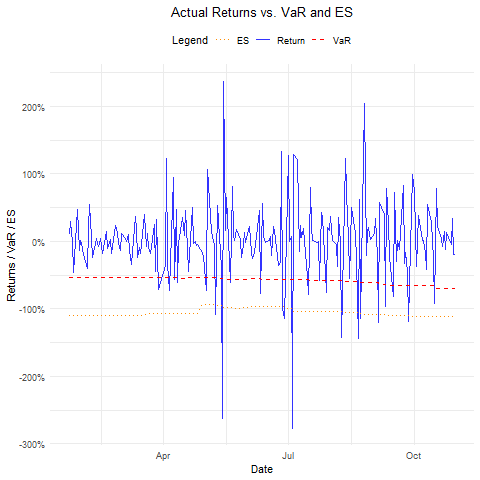

In [11]:
%%R
source(r_non_param_path)

result <- forecast_u_HS_var(df, c, n, m)

var <- -result$VaR
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

es <- -result$ES
print(ESTest(c, returns, es, var))

plot_var_es(dates, returns, var, es)

$expected.exceed
[1] 10

$actual.exceed
[1] 18

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 5.501992

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.01899483

$uc.Decision
[1] "Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 5.833391

$cc.critical
[1] 5.991465

$cc.LRp
[1] 0.05411222

$cc.Decision
[1] "Fail to Reject H0"

$expected.exceed
[1] 10

$actual.exceed
[1] 18

$H1
[1] "Mean of Excess Violations of VaR is greater than zero"

$boot.p.value
[1] NA

$p.value
[1] 0.5752495

$Decision
[1] "Fail to Reject H0"



Calculations completed.



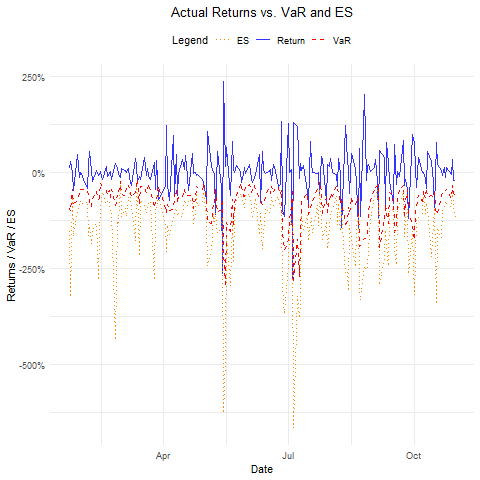

In [12]:
%%R
source(r_non_param_path)

result <- forecast_u_FHS_GARCH_var(df, c, n, m, b = 100)

var <- -result$VaR
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

es <- -result$ES
print(ESTest(c, returns, es, var))

plot_var_es(dates, returns, var, es)

$expected.exceed
[1] 10

$actual.exceed
[1] 24

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 15.08039

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.0001030279

$uc.Decision
[1] "Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 21.68404

$cc.critical
[1] 5.991465

$cc.LRp
[1] 1.956006e-05

$cc.Decision
[1] "Reject H0"

$expected.exceed
[1] 10

$actual.exceed
[1] 24

$H1
[1] "Mean of Excess Violations of VaR is greater than zero"

$boot.p.value
[1] NA

$p.value
[1] 0.4547067

$Decision
[1] "Fail to Reject H0"


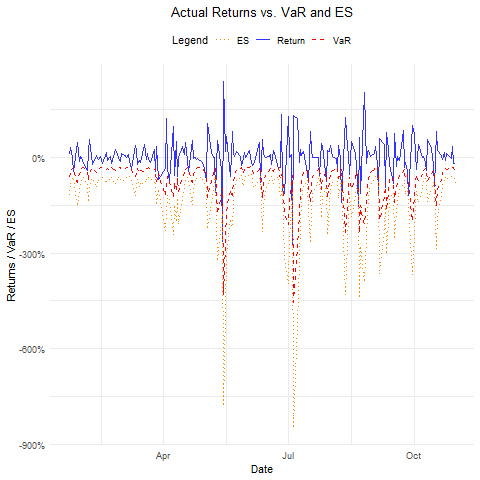

In [31]:
%%R
source(r_arch_models_path)

result <- forecast_u_GARCH_var(df, c, n, m, 1, 1, r = 10, model = "gjrGARCH", dist = "sstd")

var <- -result$VaR
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

es <- -result$ES
print(ESTest(c, returns, es, var))

plot_var_es(dates, returns, var, es)

$expected.exceed
[1] 10

$actual.exceed
[1] 22

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 11.4665

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.0007086209

$uc.Decision
[1] "Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 16.94959
$cc.critical
[1] 5.991465

$cc.LRp
[1] 0.0002086616

$cc.Decision
[1] "Reject H0"

$expected.exceed
[1] 10

$actual.exceed
[1] 22

$H1
[1] "Mean of Excess Violations of VaR is greater than zero"

$boot.p.value
[1] NA

$p.value
[1] 0.9339958

$Decision
[1] "Fail to Reject H0"



Attaching package: 'GAS'

The following objects are masked from 'package:rugarch':

    convergence, pit, residuals

The following object is masked from 'package:stats':

    residuals

In addition: Warning message:
package 'GAS' was built under R version 4.4.2 


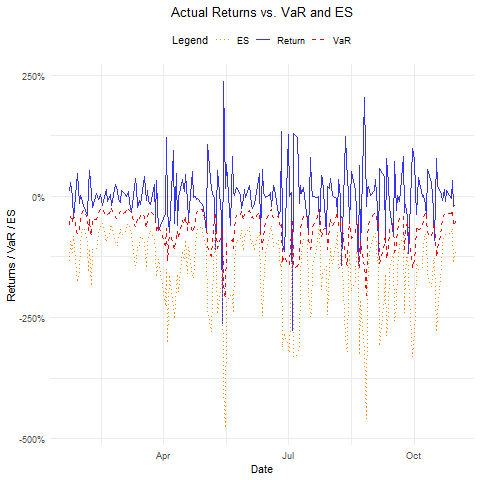

In [32]:
%%R
source(r_gas_models_path)

result <- forecast_u_GAS_var(df, c, n, m, r = 20, dist = "sstd")

var <- -result$VaR
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

es <- -result$ES
print(ESTest(c, returns, es, var))

plot_var_es(dates, returns, var, es)

$expected.exceed
[1] 10

$actual.exceed
[1] 14

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 1.50603

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.2197458

$uc.Decision
[1] "Fail to Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 3.626976

$cc.critical
[1] 5.991465

$cc.LRp
[1] 0.1630843

$cc.Decision
[1] "Fail to Reject H0"

$expected.exceed
[1] 10

$actual.exceed
[1] 14

$H1
[1] "Mean of Excess Violations of VaR is greater than zero"

$boot.p.value
[1] NA

$p.value
[1] 0.6929909

$Decision
[1] "Fail to Reject H0"



Attaching package: 'evir'

The following object is masked from 'package:ggplot2':

    qplot

In addition: There were 50 or more warnings (use warnings() to see the first 50)


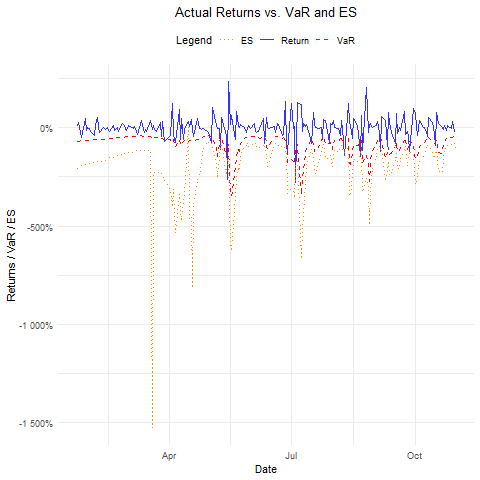

In [33]:
%%R
source(r_hybrid_evt_models_path)

result <- forecast_u_EVT_GARCH_var(df, c, n, m, t = 0.95)

var <- -result$VaR
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

es <- -result$ES
print(ESTest(c, returns, es, var))

plot_var_es(dates, returns, var, es)

$expected.exceed
[1] 10

$actual.exceed
[1] 2

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 9.89446

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.001657771

$uc.Decision
[1] "Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 9.93507
$cc.critical
[1] 5.991465

$cc.LRp
[1] 0.006960285

$cc.Decision
[1] "Reject H0"

$expected.exceed
[1] 10

$actual.exceed
[1] 2

$H1
[1] "Mean of Excess Violations of VaR is greater than zero"

$boot.p.value
[1] NA

$p.value
[1] 0.06989844

$Decision
[1] "Fail to Reject H0"


In addition: There were 50 or more warnings (use warnings() to see the first 50)


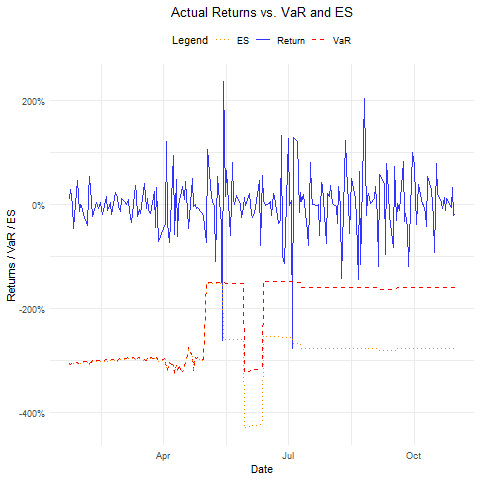

In [36]:
%%R
source(r_caviar_models_path)

result <- forecast_u_CAViaR_var(df, c, n, m, r = 10, var_model = "adaptive", itermax = 100, verbose = FALSE, es_model="ar", lb = -10, ub = 10)

var <- -result$VaR
VaRplot(c, returns, var)
print(VaRTest(c, returns, var))

es <- -result$ES
print(ESTest(c, returns, es, var))

plot_var_es(dates, returns, var, es)

In [35]:
%%R
library(quantreg)

qreg_model <- rq(df_all$Return ~ 1, tau = c)
print(summary(qreg_model))

Loading required package: SparseM
Error in model.frame.default(formula = df_all$Return ~ 1, drop.unused.levels = TRUE) : 
  invalid type (NULL) for variable 'df_all$Return'


RInterpreterError: Failed to parse and evaluate line 'library(quantreg)\n\nqreg_model <- rq(df_all$Return ~ 1, tau = c)\nprint(summary(qreg_model))\n'.
R error message: "Error in model.frame.default(formula = df_all$Return ~ 1, drop.unused.levels = TRUE) : \n  invalid type (NULL) for variable 'df_all$Return'"
R stdout:
Loading required package: SparseM
Error in model.frame.default(formula = df_all$Return ~ 1, drop.unused.levels = TRUE) : 
  invalid type (NULL) for variable 'df_all$Return'

In [ ]:
%%R
library(rugarch)

print(VaRTest(c, returns, var))

In [ ]:
%%R
library("ggplot2")             

ggplot(df, aes(x=`Date`, y=`NPE EDEFB D1 - return`)) +
    geom_line(color="blue") +
    ggtitle("NPE EDEFB D1 Returns") +
    xlab("Date") +
    ylab("Return (%)")

In [ ]:
models_dir = project_dir / "src" / "var_es_toolbox" / "backtesting"
r_backtesting_path = models_dir / "r_backtesting.R"
r.source(str(r_backtesting_path))

backtest_er = r["backtest_er"]
backtest_er_result = backtest_er([0.1], [5], [4.5], [30], 1000)

globalenv['r_backtesting_path'] = str(r_backtesting_path)

In [ ]:
%%R

source(r_backtesting_path)
result <- backtest_er(df, p, q, n)
print(result)

In [ ]:
p = 1
q = 1
n = 5
mean = "constant"
vol = "garch"
dist = "normal"

basic_gm = arch_model(futures_returns, p=p, q=q, mean=mean, vol=vol, dist=dist)

gm_result = basic_gm.fit()
print(gm_result.summary())
gm_result.plot()

# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon=n)

# Print the forecast variance
print(gm_forecast.variance[-1:])

# Calculate standardized residual
gm_std_resid = gm_result.resid / gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')

forecast_garch_result = forecast_ugarch(futures_returns, p=p, q=q, n=n, verbose=0, mean=mean, dist=dist)
print(forecast_garch_result.variance)